[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly_into_non_simply_connected_shapes.ipynb)

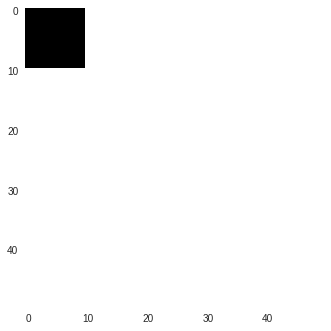

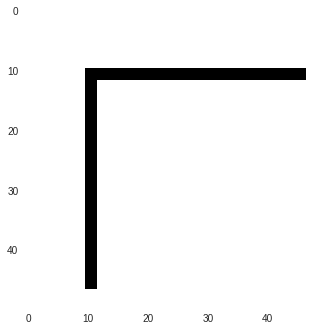

[(10, 10), (10, 11), (10, 12), (10, 13), (10, 14)]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# initial coordinates for agents
L = 10
scaling_factor = 5
gridshape = (scaling_factor*L,scaling_factor*L)
grid = np.zeros(gridshape)
grid[:L,:L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

# make shape
shape = np.zeros(gridshape)
shape[L:-3,L:-3] = 1
shape[int(1.25*L):-3,int(1.25*L):-3] = 0 

plt.imshow(shape)
plt.grid(False)
plt.show()

shape_coordinates = []
for x in range(shape.shape[0]):
  for y in range(shape.shape[1]):
    if shape[x,y] == 1:
      shape_coordinates.append((x,y))
shape_coordinates[:5]

In [2]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = []
for x in range(L):
  for y in range(L):
    if grid[x,y]==1:
      agents.append({'true_coordinates':(x,y),'estimated_coordinates':(x,y),'id':len(agents),'is_source':bool((x,y)==(L-1,L-1))})

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_distances_estimations(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  estimated_coordinates = agent['estimated_coordinates']
  
  if len(neighbors)>0:
  
    neighbors_estimated_coordinates = [agents[n]['estimated_coordinates'] for n in neighbors]
    # DEBUG: print 'neighbors for agent id ',agent['id'],' at ',center,'are: ',neighbors
    def error_estimated_coordinates(xy):
      discrepancies = [d - distance_metric(xy,neighbors_estimated_coordinates[i]) for i,d in enumerate(distances)]
      return sum([abs(d) for d in discrepancies])

    neighbors_estimated_coordinates_x = [c[0] for c in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [c[1] for c in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x,max_x+1),range(min_y,max_y+1)))
    candidate_estimation_errors = [error_estimated_coordinates(xy) for xy in candidate_estimations]

    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
  
  return [neighbors,distances,estimated_coordinates]


for a in agents:
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (0, 0),
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'true_coordinates': (0, 0)}

In [3]:
# initialize gradient values. source agent is at (L-1,L-1)

for a in agents:
  if a['is_source']:
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (0, 0),
 'gradient_value': 9,
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'true_coordinates': (0, 0)}

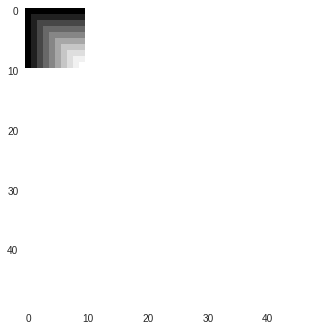

In [4]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [6]:
# edge-following

def valid_prospective_displacements(agent):

  def is_in_grid_and_not_occupied(agent, prospective_displacement):
    
    if prospective_displacement == (0,0):
      return True
    else:
      (x,y) = agent['true_coordinates']
      (dx,dy) = prospective_displacement
      prospective_coordinates = (x+dx,y+dy)
      if prospective_coordinates[0]<0 or prospective_coordinates[1]<0:
        return False
      else:
        ans = True
        for n in unit_neighbors(agent):
          if prospective_coordinates==agents[n]['true_coordinates']:
            ans = False
            break
        return ans
  
  #def is_reversal(agent,prospective_displacement):
  #  if prospective_displacement==(0,0) or previous_displacement==(0,0):
  #    return False
  #  else:
  #    if (prospective_displacement[0]+previous_displacement[0],prospective_displacement[1]+previous_displacement[1]) == (0,0):
  #      return True
  #    else:
  #      return False
    
  def unit_neighbors(agent):
    return [n for i,n in enumerate(agent['neighbors']) if agent['distances'][i]==1]
  
  def get_prospective_agent(agent,prospective_displacement):
    (x_est,y_est) = agent['estimated_coordinates']
    (x_true,y_true) = agent['true_coordinates']
    
    prospective_agent = agent.copy()
    prospective_agent['true_coordinates'] = (x_true+prospective_displacement[0],y_true+prospective_displacement[1])
    # DEBUG: print 'get_neighbors_distances_estimations called in get_prospective_agent with displacement',prospective_displacement
    [prospective_agent['neighbors'],prospective_agent['distances'],prospective_agent['estimated_coordinates']] = get_neighbors_distances_estimations(prospective_agent)
    return prospective_agent

  def is_isolating(agent,prospective_displacement):
    # DEBUG: print 'get_prospective_agent called in is_isolating'
    prospective_agent = get_prospective_agent(agent,prospective_displacement)
    self_isolating = (1 not in prospective_agent['distances'])
    is_isolating = bool(self_isolating)
    if not is_isolating: # need to check if it isolated any unit neighbors
      for n in unit_neighbors(agent):
        if len(unit_neighbors(agents[n])) == 1: # isolation can only occur if agent is unit neighbor's only unit neighbor
          if n not in unit_neighbors(prospective_agent): # check if agent is no longer neighbor to this unit neighbor
            is_isolating = True
            break
    return is_isolating

  if agent['is_source']:
    return [(0,0)]
  else:
    prospective_displacements = list(itertools.product([-1,0,1],[-1,0,1]))
    valid_prospective_displacements = []
    for d in prospective_displacements:
      if is_in_grid_and_not_occupied(agent,d):
        #if not is_reversal(agent,d):
        if not is_isolating(agent,d):
          valid_prospective_displacements.append(d)

    return valid_prospective_displacements

print valid_prospective_displacements(agents[0])
print valid_prospective_displacements(agents[-1])
print valid_prospective_displacements(agents[-2])

[(0, 0)]
[(0, 0)]
[(0, 0), (1, -1), (1, 0), (1, 1)]


In [7]:
def estimated_distance_to_shape(agent,prospective_displacement):
  (x,y) = agent['estimated_coordinates']
  (dx,dy) = prospective_displacement
  prospective_estimated_coordinates = (x+dx,y+dy)
  distances = [distance_metric(prospective_estimated_coordinates,p) for p in shape_coordinates]
  return min(distances)

def chosen_displacement(agent,shape_coordinates):
  displacements = valid_prospective_displacements(agent)
  distances = [estimated_distance_to_shape(agents[-2],d) for d in displacements]
  min_distance = min(distances)
  optimal_displacements = [displacements[i] for i,d in enumerate(distances) if d==min_distance]
  return random.choice(optimal_displacements)

print [estimated_distance_to_shape(agents[-2],d) for d in valid_prospective_displacements(agents[-2])]
print chosen_displacement(agents[-2],shape_coordinates)
#def edge_follow(agent,shape_coordinates):
#  return get_prospective_agent(agent,best_displacement(agent,shape_coordinates))

[2, 3, 2, 1]
(1, 1)


In [0]:
original_agents = [a.copy() for a in agents]
def reset_agents():
  agents = [a.copy() for a in original_agents]

In [0]:
def timestep(agents=agents,shape_coordinates=shape_coordinates):
  movable_agents = [i for i,a in enumerate(agents) if len(valid_prospective_displacements(a))>1]
  selected_agent = agents[random.choice(movable_agents)]
  (x,y) = selected_agent['true_coordinates']
  (dx,dy) = chosen_displacement(selected_agent,shape_coordinates)
    
  selected_agent['true_coordinates'] = (x+dx,y+dy)
  previous_neighbors = selected_agent['neighbors']
  
  def update_agent(a):
    [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  update_agent(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  agents_to_update = list(set(previous_neighbors).union(set(new_neighbors)))
  for i in agents_to_update:
    update_agent(agents[i])  

def plot_grid():
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
  plt.imshow(grid)
  plt.grid(False)
  plt.show()

t=0


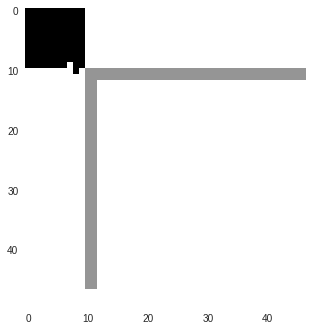

t=100


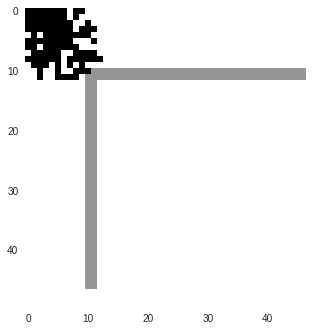

t=200


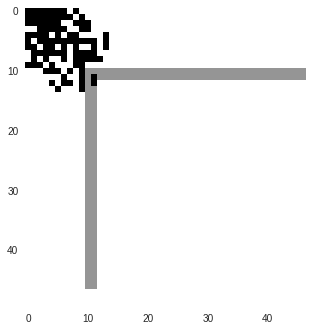

t=300


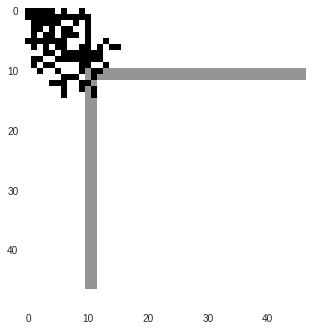

t=400


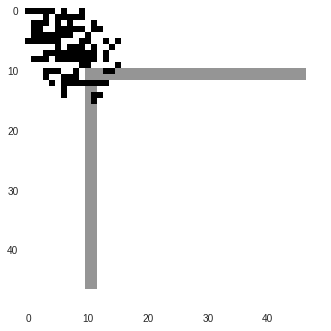

t=500


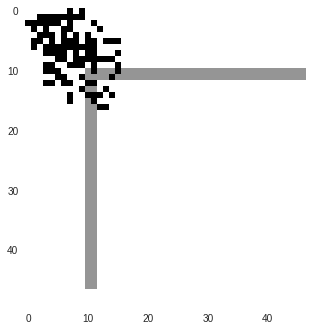

t=600


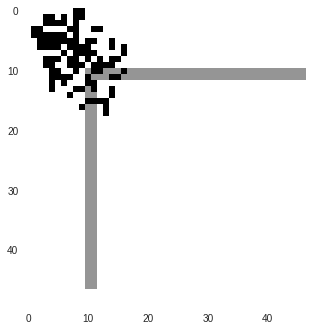

t=700


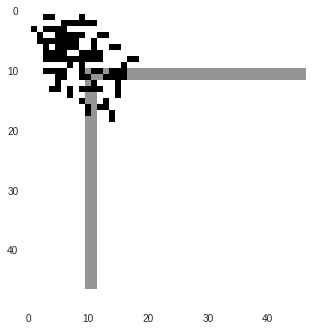

t=800


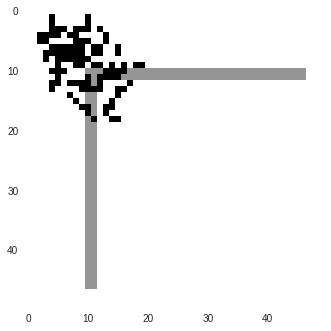

t=900


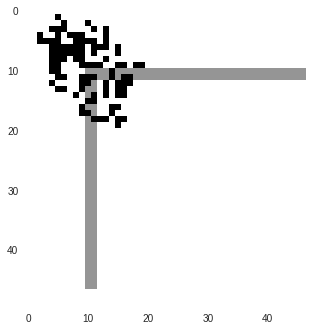

In [10]:
for t in range(1000):
  timestep()
  if t%100==0:
    print 't='+str(t)
    plot_grid()